In [72]:
import pandas as pd
import geopandas as gpd
import ast
import requests
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

#### Загрузим датасет с данными о достопримечательностях в России

In [31]:
df = pd.read_csv('./Downloads/tourist_attractions.csv')
df.head()

,name,type,region,locality,geolocation
0,"The ""second"" home shopping store ""IJ Churin an...",architecture,Amur region,Blagoveshchensk,"(Decimal('127.548877'), Decimal('49.811568'))"
1,"""Town of security officers""",architecture,Sverdlovsk region,Ekaterinburg,"(Decimal('60.621271'), Decimal('56.841798'))"
2,"""Palace for the beloved""",architecture,Kursk region,Safonovka,"(Decimal('35.139965'), Decimal('51.491293'))"
3,"""The House with The Firebird"" (manor Zhelyabov...",architecture,Tomsk region,Tomsk,"(Decimal('85.050946'), Decimal('56.469513'))"
4,"""House with the ghosts""",architecture,Novosibirsk region,Novosibirsk,"(Decimal('82.958761'), Decimal('55.041787'))"


In [32]:
def extract_lat_lon(geo_str):
    if pd.isna(geo_str):
        return None, None
    lat_lon = re.findall(r"Decimal\('([0-9.-]+)'\)", geo_str)
    if lat_lon:
        return float(lat_lon[1]), float(lat_lon[0])  # Первая цифра широта, вторая долгота
    else:
        return None, None

# Разделение колонки geolocation на две новые колонки
df[['latitude', 'longitude']] = pd.DataFrame(df['geolocation'].apply(extract_lat_lon).tolist(), index=df.index)

df.tail()


,name,type,region,locality,geolocation,latitude,longitude
5236,Khunzakh fortress,defenses,The Republic of Dagestan,Khunzakh,"(Decimal('46.702459'), Decimal('42.538574'))",42.538574,46.702459
5237,Tsitadel 'Regional',defenses,The Republic of Dagestan,Derbent,"(Decimal('48.288776'), Decimal('42.057669'))",42.057669,48.288776
5238,"Citadel ""Pillai""",defenses,Kaliningrad region,NaN,"(Decimal('19.892177'), Decimal('54.644072'))",54.644072,19.892177
5239,Anna's fortress,defenses,Rostov region,Starocherkasskaya,"(Decimal('40.037562'), Decimal('47.238844'))",47.238844,40.037562
5240,Peter-Pavel's Fortress,defenses,St. Petersburg,NaN,"(Decimal('30.307792'), Decimal('59.948978'))",59.948978,30.307792


#### Загрузим данные о погоде из OpenWeatherMap по координатам 

In [4]:
#API ключ для OpenWeatherMap
api_key = 'e751d88c3b09a02558cc49d2cd4803e2'
base_url = 'http://api.openweathermap.org/data/2.5/weather'


In [55]:
%%time

weather_data_list = []

for index, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    params = {
        'lat': lat,
        'lon': lon,
        'units': 'metric',  # для получения температуры в градусах Цельсия
        'appid': api_key
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    temp = data.get('main', {}).get('temp', None)
    weather_data_list.append({
        'name': row['name'],
        'type': row['type'],
        'region': row['region'],
        'locality': row['locality'],
        'temperature': temp,
        'weather': data.get('weather', [{}])[0].get('main'),
        'latitude': lat,
        'longitude': lon
    })


weather_data = pd.DataFrame(weather_data_list)



CPU times: user 52.4 s, sys: 8.43 s, total: 1min
Wall time: 18min 55s


In [56]:
weather_data

,name,type,region,locality,temperature,weather,latitude,longitude
0,"The ""second"" home shopping store ""IJ Churin an...",architecture,Amur region,Blagoveshchensk,-8.85,Clear,49.811568,127.548877
1,"""Town of security officers""",architecture,Sverdlovsk region,Ekaterinburg,-8.37,Clouds,56.841798,60.621271
2,"""Palace for the beloved""",architecture,Kursk region,Safonovka,-1.30,Clouds,51.491293,35.139965
3,"""The House with The Firebird"" (manor Zhelyabov...",architecture,Tomsk region,Tomsk,-9.15,Clouds,56.469513,85.050946
4,"""House with the ghosts""",architecture,Novosibirsk region,Novosibirsk,-8.35,Clouds,55.041787,82.958761
...,...,...,...,...,...,...,...,...
5236,Khunzakh fortress,defenses,The Republic of Dagestan,Khunzakh,3.81,Clouds,42.538574,46.702459
5237,Tsitadel 'Regional',defenses,The Republic of Dagestan,Derbent,13.79,Clouds,42.057669,48.288776
5238,"Citadel ""Pillai""",defenses,Kaliningrad region,NaN,0.20,Clouds,54.644072,19.892177
5239,Anna's fortress,defenses,Rostov region,Starocherkasskaya,5.57,Rain,47.238844,40.037562


In [57]:
# распределение температуры и видов погоды
display(weather_data['temperature'].describe())
display(weather_data['weather'].value_counts())

count    4087.000000
mean       -4.117651
std         6.184115
min       -34.910000
25%        -6.870000
50%        -5.590000
75%        -1.210000
max        13.790000
Name: temperature, dtype: float64

weather
Clouds     3157
Clear       471
Snow        221
Rain        211
Mist         20
Drizzle       5
Fog           2
Name: count, dtype: int64

In [58]:
# Проверка надичия пропусков
display(weather_data['latitude'].isna().sum())
display(weather_data['longitude'].isna().sum())
display(weather_data['weather'].isna().sum())
display(weather_data['temperature'].isna().sum())

1154

1154

1154

1154

In [73]:
# в каких регионах находятся достопримечательности без координат
ll = weather_data.query('longitude!=longitude')
ll['region'].value_counts()

region
Volgograd region                      44
Leningrad region                      41
Sverdlovsk region                     41
Nizhny Novgorod Region                40
Smolensk region                       35
Rostov region                         33
Yaroslavskaya oblast                  31
Krasnodar region                      31
Moscow                                30
Vladimir region                       30
The Republic of Buryatia              27
Kaliningrad region                    26
Perm                                  25
Pskov region                          25
Tula region                           25
Lipetsk region                        25
Novosibirsk region                    23
Novgorod region                       22
Mari El Republic                      21
Tver region                           21
St. Petersburg                        20
Yamalo-Nenets Autonomous Okrug        20
The Republic of Dagestan              19
Khanty-Mansi Autonomous Area          19
Arhangels

#### Визуализация

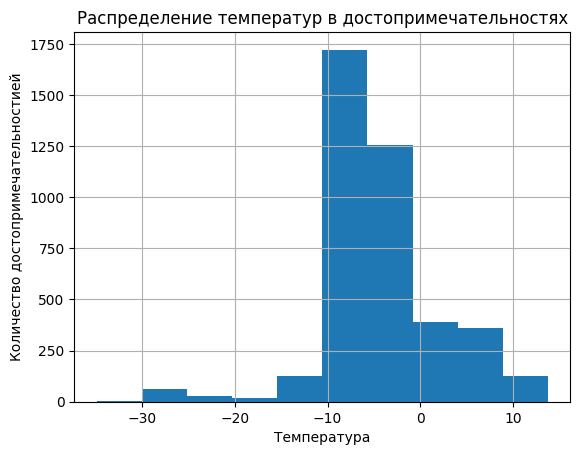

In [63]:
# Гистограмма температур
weather_data['temperature'].hist()
plt.title('Распределение температур в достопримечательностях')
plt.xlabel('Температура')
plt.ylabel('Количество достопримечательностией')
plt.show()



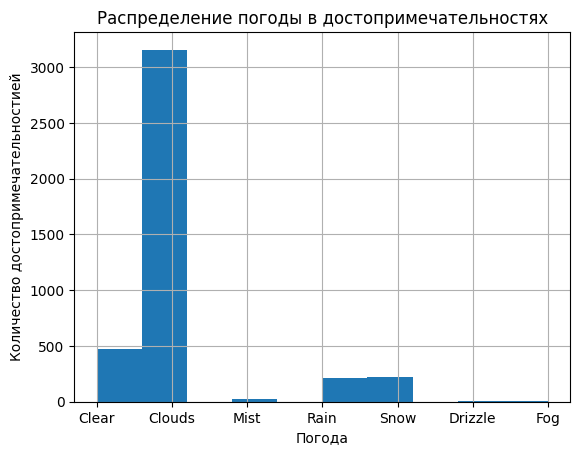

In [64]:
# Гистограмма температур
weather_data['weather'].hist()
plt.title('Распределение погоды в достопримечательностях')
plt.xlabel('Погода')
plt.ylabel('Количество достопримечательностией')
plt.show()


In [65]:
df_map = weather_data.query('latitude == latitude')

In [66]:
fig = px.scatter_geo(df_map,
                     lat='latitude',
                     lon='longitude',
                     hover_name='name',  
                     hover_data={'temperature': True, 'weather': True},  
                     title='Достопримечательности и Погода')


fig.show()

# карта в HTML файл:
fig.write_html('attractions_weather_map.html')

In [71]:

fig = go.Figure(data=go.Scattergeo(
    lon = df_map['longitude'],
    lat = df_map['latitude'],
    text = df_map['name'] + ': ' +df_map['temperature'].astype(str) + ', ' + df_map['weather'],
    mode = 'markers',
    marker = dict(
        size = 8,
        opacity = 0.8,
        reversescale = True,
        autocolorscale = False,
        symbol = 'square',
        line = dict(
            width=1,
            color='rgba(102, 102, 102)'
        ),
        colorscale = 'OrRd',
        cmin = df_map['temperature'].min(),
        color = df_map['temperature'],
        cmax = df_map['temperature'].max(),
        colorbar_title="Temperature (°C)"
    )
))

fig.update_layout(
    title = 'Temperature and Weather Data by Location',
    geo = dict(
        scope='world',
        showland = True,
    )
)


fig.show()
